# Sandbox

In [1]:
import numpy as np
import qutip as qt
import torch
import matplotlib.pyplot as plt
import sys
import os
import importlib

In [2]:
sys.path.append('..')

In [69]:
import alpha_zero as az
import pulse_sequences as ps

In [87]:
# importlib.reload(az)
importlib.reload(ps)

<module 'pulse_sequences' from '../pulse_sequences.py'>

## Testing network

In [4]:
Utarget = qt.identity([2] * 3)

In [5]:
config = az.Config()

In [6]:
ps_config = ps.PulseSequenceConfig(Utarget=Utarget, ensemble_size=50)

In [8]:
# net = az.Network()
# net.load_state_dict(torch.load('0008000-network'))

In [54]:
ps_config.reset()
output = az.make_sequence(config, ps_config, network=net, test=False, rng=ps_config.rng)

In [55]:
print(output[-1])

([4, 2, 2, 1, 2, 2, 1, 1, 4, 0, 0, 3, 4, 0, 1, 0, 0, 0, 1, 1, 4, 3, 0, 0, 2, 4, 4, 0, 0, 4, 0, 0, 0, 2, 2, 0, 1, 0, 2, 0, 0, 2, 4, 0, 0, 0, 0], array([1., 0., 0., 0., 0.]), 2.3924550431950924)


## Testing ps_config parameter saving

In [216]:
output = np.load('../scripts/ps_config-0-no_net.npz')

In [222]:
np.std(output['rots'])

0.009820976650951307

In [202]:
cs = output['chemical_shifts']
dip_mat = output['dipolar_matrices']

In [203]:
N=3

In [204]:
Hsys_ensemble = []
offset = 0
for chemical_shifts, dipolar_matrix in zip(cs, dip_mat):
    Hcs = sum(
        [qt.tensor(
            [qt.identity(2)] * i
            + [(offset + chemical_shifts[i]) * qt.sigmaz()]
            + [qt.identity(2)] * (N - i - 1)
        ) for i in range(N)]
    )
    # dipolar interactions
    Hdip = sum([
        dipolar_matrix[i, j] * (
            2 * qt.tensor(
                [qt.identity(2)] * i
                + [qt.sigmaz()]
                + [qt.identity(2)] * (j - i - 1)
                + [qt.sigmaz()]
                + [qt.identity(2)] * (N - j - 1)
            )
            - qt.tensor(
                [qt.identity(2)] * i
                + [qt.sigmax()]
                + [qt.identity(2)] * (j - i - 1)
                + [qt.sigmax()]
                + [qt.identity(2)] * (N - j - 1)
            )
            - qt.tensor(
                [qt.identity(2)] * i
                + [qt.sigmay()]
                + [qt.identity(2)] * (j - i - 1)
                + [qt.sigmay()]
                + [qt.identity(2)] * (N - j - 1)
            )
        )
        for i in range(N) for j in range(i + 1, N)
    ])
    
    Hsys_ensemble.append(Hcs + Hdip)

In [213]:
pulses_ensemble = []
for H in Hsys_ensemble:
    rot = np.random.normal(scale=0.01)
    pulses_ensemble.append(
        ps.get_pulses(H, X, Y, Z, pulse_width=1e-5, delay=1e-4, rot_error=rot)
    )

In [214]:
f = ps.get_mean_fidelity([3, 4, 4, 2, 4, 4, 2, 2, 3, 3, 2, 3], Utarget, pulses_ensemble)
-np.log10(1 - f)

2.5015571286258496

## Simulation

In [83]:
Hsys, params = ps.get_Hsys(N=3, offset=1e0, dipolar_strength=1e2, return_all=True)

In [84]:
X, Y, Z = ps.get_collective_spin(N=3)

In [88]:
output = qt.mesolve(Hsys, X, tlist=np.linspace(0, 15e-2, 500), e_ops=[X, Y, Z])

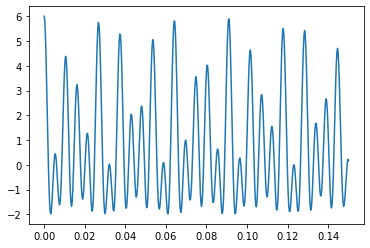

In [89]:
plt.plot(output.times, output.expect[0])

In [90]:
params

(array([0.56365476, 0.13010873, 0.8971216 ]),
 0.20856764728178212,
 array([[-127.71305054, -145.45596682,   84.50100052],
        [ -17.43951414,  101.06205672,   26.8447102 ],
        [-181.97074045,  -41.18745734,  -14.02630326]]))

In [123]:
pulses = ps.get_pulses(Hsys, X, Y, Z, pulse_width=1e-5, delay=1e-4, phase_transient=0)

In [122]:
(pulses[1] * pulses[1] * pulses[1] * pulses[1]).tr()/8

(-0.9957933313517151+3.114655634936449e-05j)

In [91]:
ps.get_pulses

<function pulse_sequences.get_pulses(Hsys, X, Y, Z, pulse_width=0.0001, delay=0.001, rot_error=0, phase_transient=0, rng=None)>

## ML

In [131]:
import torch
import numpy as np
import torch.multiprocessing as mp
from time import sleep
from torch.utils.tensorboard import SummaryWriter

In [129]:
import alpha_zero as az

In [132]:
writer = SummaryWriter('runs/sandbox')

In [133]:
net = az.Network()

In [145]:
net

Network(
  (gru): GRU(6, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=32, bias=True)
  (policy): Linear(in_features=32, out_features=5, bias=True)
  (value): Linear(in_features=32, out_features=1, bias=True)
)

In [143]:
input = torch.zeros((1, 10, 6))

In [144]:
writer.add_graph(net, input)

In [45]:
def worker(proc_num, queue):
    for _ in range(6000):
        if _ % 500 == 0:
            print(f'in {proc_num} on iteration {_}')
        rng = np.random.default_rng()
        length = rng.integers(48)
        state = rng.random(size=(length, 6))
        probs = rng.random(size=(5,))
        value = rng.random(size=(1,))
        datum = (state, probs, value)
        queue.put(datum)
#         with lock:
#             if len(buffer) < buffer_size:
#                 buffer.append(datum)
#                 index.value += 1
#             else:
#                 buffer[index.value] = datum
#                 index.value += 1
#             if index.value >= buffer_size:
#                 index.value = 0
    return


def checker(queue, output, buffer_size=24000):
    buffer = []
    index = 0
    while len(buffer) < buffer_size:
        if queue.empty():
            sleep(1)
            continue
        buffer.append(queue.get())
        index += 1
    output.put(buffer)

In [2]:
if __name__ == '__main__':
    # TODO start processes, try adding 450 * 48 * (tensor, tensor, tensor) to shared list
    # and see if I run into similar issues...
    with mp.Manager() as manager:
        queue = manager.Queue()
        output = manager.Queue()
#         length = manager.Value('i', 0)
#         index = manager.Value('i', 0)
#         lock = manager.Lock()
        workers = []
        for i in range(4):
            w = mp.Process(target=worker, args=(i, queue))
            w.start()
            workers.append(w)
        w = mp.Process(target=checker, args=(queue, output))
        w.start()
        workers.append(w)
        for w in workers:
            w.join()
        print('all processes joined')
#         buffer = list(buffer)
#         index = index.value
        buffer = output.get()

In [41]:
buffer[2][2]

array([0.54937819])

In [47]:
[a[2] for a in buffer[:10]]

[array([0.76290919]),
 array([0.15618292]),
 array([0.79988231]),
 array([0.24052051]),
 array([0.95798373]),
 array([0.92766788]),
 array([0.49542138]),
 array([0.11634498]),
 array([0.28900658]),
 array([0.93548941])]

In [48]:
len(buffer)

24000

In [3]:
np.random.gamma(.3, 1, 5)

array([4.51142846e-05, 1.63684981e-06, 1.90767475e-01, 1.66719882e-01,
       1.15576553e-09])

In [4]:
rng = np.random.default_rng()

In [25]:
rng.gamma(.3, 1, 5)

array([0.04235174, 0.17385871, 0.00208078, 0.00103263, 0.00506793])

In [26]:
rng.dirichlet([1e-1] * 5)

array([2.93925569e-03, 9.96016686e-01, 1.04404191e-03, 5.75735218e-20,
       1.66749759e-08])

## Getting tensorboard data

In [1]:
import tensorflow as tf
import tensorboard as tb

In [ ]:
from tensorflow

In [2]:
import tensorboard.backend.event_processing as ep

In [8]:
import tensorboard.backend.event_processing.event_file_loader as efl

In [52]:
loader = efl.EventFileLoader('../../data/2021-02/20210219-082529/Feb19_08-25-29_k38.hpcc.dartmouth.edu/events.out.tfevents.1613741129.k38.hpcc.dartmouth.edu.14002.0')

In [53]:
events = []
for event in loader.Load():
    events.append(event)

In [54]:
len(events)

146628

In [57]:
hist_events = [a for a in events if 'hist' in str(a)]

In [80]:
a = hist_events[0].summary.value[0].histo

In [87]:
len(a.bucket), len(a.bucket_limit)

(600, 600)

In [89]:
hist_events[0].step

0

In [90]:
steps, buckets, bucket_limits = zip(*[
    (a.step, a.summary.value[0].histo.bucket, a.summary.value[0].histo.bucket_limit)
    for a in hist_events
])

In [93]:
# TODO write the histogram data to a file
# TODO also figure out if I can make a video animating histogram over time...

In [109]:
import matplotlib.pyplot as plt

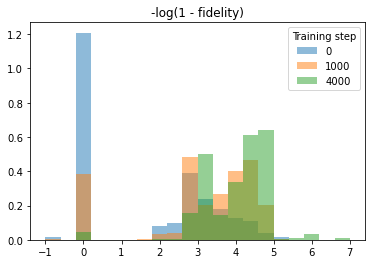

In [141]:
plt.hist(bucket_limits[0], bins=20, weights=buckets[0], range=(-1, 7),
         density=True, alpha=0.5, label='0')
plt.hist(bucket_limits[100], bins=20, weights=buckets[100], range=(-1, 7),
         density=True, alpha=0.5, label='1000')
plt.hist(bucket_limits[400], bins=20, weights=buckets[400], range=(-1, 7),
         density=True, alpha=0.5, label='4000')
plt.legend(title='Training step')
plt.title('-log(1 - fidelity)')
plt.show()

In [119]:
len(bucket_limits)

486

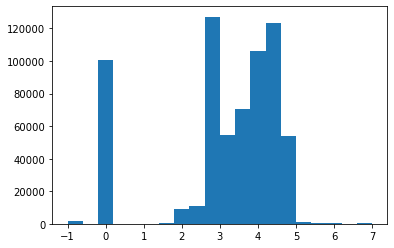

In [123]:
plt.hist(bucket_limits[100], bins=20, weights=buckets[100], range=(-1, 7))
plt.show()

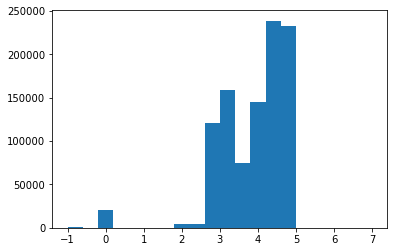

In [127]:
plt.hist(bucket_limits[200], bins=20, weights=buckets[200], range=(-1, 7))
plt.show()

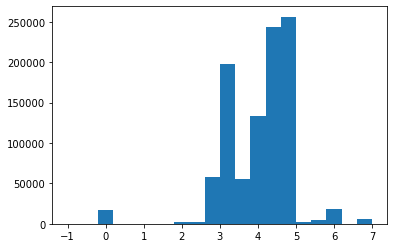

In [118]:
plt.hist(bucket_limits[-1], bins=20, weights=buckets[-1], range=(-1, 7))
plt.show()